In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import networkx as nx
import torch
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score

import generators as gen
import optimize as opt
import helpers as hlp
from NNet import NNet

from mpl_toolkits.basemap import Basemap

%load_ext autoreload
%autoreload 2


In [2]:
def plot_results(imp, h):
    plt.figure(figsize=(12,4))
    
    plt.subplot(131)
    plt.imshow(imp>.5)
    plt.title('Rounded Imputed Values')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(imp)
    plt.title('Imputed Values')
    plt.axis('off')

    L = hlp.A_to_L(imp>.5)
    plt.subplot(133)
    evals, _ = np.linalg.eig(L)
    x = torch.Tensor(np.linspace(0.01,evals.max()+1, num=100)).unsqueeze_(-1)
    plt.plot(x.numpy(), h(x).detach().numpy())
    plt.legend(['Fitted', 'True'])
    plt.xlabel('Eigenvalue')
    plt.ylabel('Kernel');

In [3]:
fn = 'data/Complete_TAVG_EqualArea.nc'
ds = nc.Dataset(fn)

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: Berkeley Earth Internal Convention (based on CF-1.5)
    title: Native Format Berkeley Earth Surface Temperature Anomaly Field
    history: 06-Sep-2020 00:15:07
    institution: Berkeley Earth Surface Temperature Project
    source_file: Complete_TAVG.50500s.20200906T000510.mat
    source_history: 03-Sep-2020 08:08:23
    source_data_version: 818945c4afba679e5679ec89e2b8cd1d
    comment: This file contains Berkeley Earth surface temperature anomaly field in our native equal-area format.
    dimensions(sizes): map_points(5498), time(3248), month_number(12)
    variables(dimensions): float32 longitude(map_points), float32 latitude(map_points), float64 time(time), float64 land_mask(map_points), float32 temperature(time,map_points), float32 climatology(month_number,map_points)
    groups: 



In [5]:
temp = np.array(ds['temperature'])
time = np.array(ds['time'])
long = np.array(ds['longitude'])
lati = np.array(ds['latitude'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [6]:
touse_t = ~np.isnan(temp.sum(axis=1))

In [7]:
touse_xy = (lati>=36) & (lati <65) & (long>-11) & (long < 30)

In [8]:
temp_use = temp[touse_t][:, touse_xy]
time_use = time[touse_t]
long_use = long[touse_xy]
lati_use = lati[touse_xy]

In [9]:
imp, hist, h = opt.impute_graph(temp_use, lr=.01, nit_nnet=3, lr_nnet=1e-5,
                               n_epochs=3000)

[Epoch 3000/3000] loss: 59.2228741

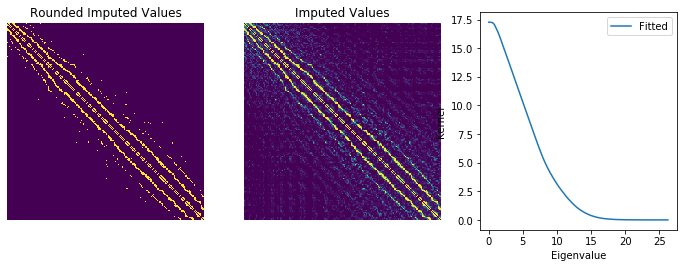

In [10]:
plot_results(imp, h)

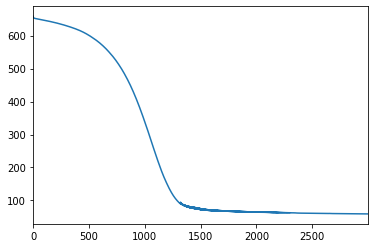

In [11]:
hist.Loss.plot()

# Interpolate Missing Values

In [25]:
def plot_graph(adj, color, cmapname='coolwarm', vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution=None,
                width=4E6, height=4E6, 
                lat_0=lati_use.mean(), lon_0=long_use.mean(),)
    m.etopo(scale=0.5, alpha=0.5)

    pos_dict = {i: m(lo, la) for i, (lo, la) in enumerate(zip(long_use, lati_use))}
    nx.draw(nx.from_numpy_array(adj), pos=pos_dict, 
            cmap=plt.get_cmap(cmapname), node_color=color,
            vmin=vmin, vmax=vmax)


In [13]:
def find_missing(adj, h, signal, mask=None, lr=1e-2, n_iters=1000, 
                 seed=42, verbose=None):
    if mask is None:
        mask = ~np.isnan(signal)
        
    target = torch.Tensor(signal[mask])
    tot_nodes = mask.sum()
    
    L = hlp.A_to_L(adj)
    h_of_L = gen.filter_matrix(L, h)
    
    torch.manual_seed(seed)
    np.random.seed(seed)
        
    generating = torch.Tensor(np.random.normal(size=signal.shape))
    generating.requires_grad = True
    optimizer = torch.optim.Adam([generating], lr=lr)
    
    for i in range(int(n_iters)):
        optimizer.zero_grad()
        filtered = generating @ h_of_L
        loss = ((filtered[mask] - target)**2).sum() / tot_nodes
        loss.backward()
        optimizer.step()
        
        if verbose and (i%verbose==0 or i==int(n_iters - 1)):
            print('\rIteration {}: Loss {}'.format(i+1, loss.item()), end='')
    
    out = gen.filter_signal(generating, L, h).detach().numpy()
    out[mask] = signal[mask]
    
    return generating, out
        


In [28]:
sign= temp_use[-1]
np.random.seed(3)
mask = np.random.uniform(size=sign.shape)>.9

generator, interp = find_missing(imp, h, sign, mask, lr=1e-2, n_iters=10000,
                                verbose=500)


Iteration 10000: Loss 4.973799150320701e-13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


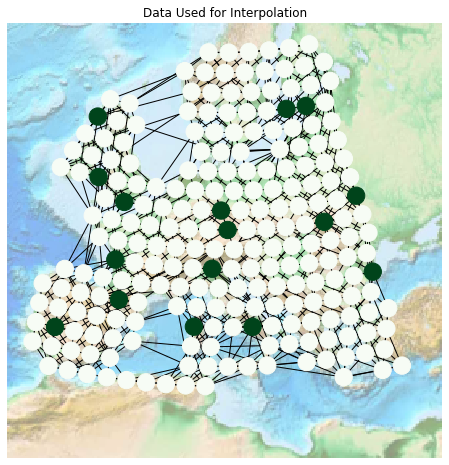

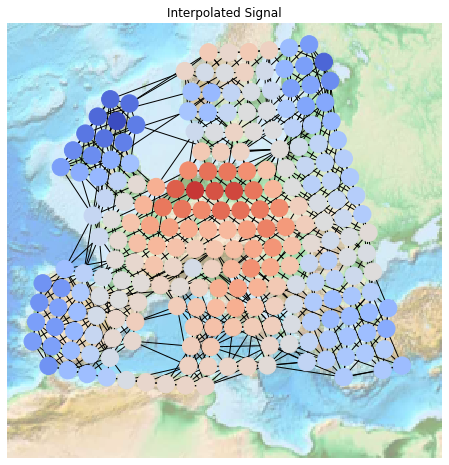

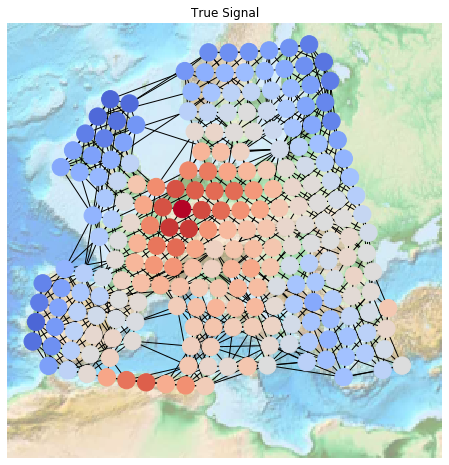

In [29]:
vmin = min(interp.min(), sign.min())
vmax = max(interp.max(), sign.max())

plot_graph(imp > .5, mask, 'Greens')
plt.title('Data Used for Interpolation')
plt.savefig('res/interp_mask.png')
plot_graph(imp > .5, interp, vmin=vmin, vmax=vmax)
plt.title('Interpolated Signal')
plt.savefig('res/interp_pred.png')
plot_graph(imp > .5, sign, vmin=vmin, vmax=vmax)
plt.title('True Signal')
plt.savefig('res/interp_true.png')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


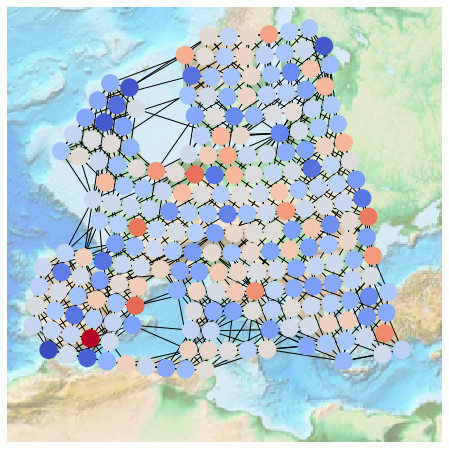

In [30]:
plot_graph(imp > .5, generator.detach().numpy())
